# Projet 5 Parcours Machine Learning (suite)

## Catégorisez automatiquement des questions



![image info](https://upload.wikimedia.org/wikipedia/commons/f/f7/Stack_Overflow_logo.png)

Stackoverflow est une célèbre plateforme d’entraide liée au monde de l’informatique. On va exploiter un jeu de données contenant des informations sur les questions posées sur le forum pour mettre au point un algorithme de suggestion de tags.

Ce notebook comprendra la partie exploration.

# 3. Apprentissage non-supervisé

Nous allons tester deux modèles d'apprentissage non-supervisés (LDA et NMF) et comparerons leurs performances en fonction de la pertinence des thèmes modélisés

## 3.1 LDA

In [18]:
# Transformation des données préalablement nettoyées grâce à tfidf qui les représentera en bags-of-words
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                   min_df=0.00,
                                   max_df = 1.00,
                                   strip_accents = None,
                                   encoding = 'utf-8', 
                                   preprocessor=None,
                                   token_pattern=r"(?u)\S\S+",
                                   max_features=2000)

In [19]:
vectorized_body=tfidf_vectorizer.fit_transform(df.Body)


In [20]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=20, max_iter=5, learning_method='online', 
                                learning_offset=50,random_state=11).fit(vectorized_body)

In [21]:
lda_model = lda.fit_transform(vectorized_body)

In [ ]:


top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=600, plot_height=600)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [69]:
# Affichage des thèmes modélisés par le modèle lda
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, tfidf_vectorizer.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
list item items sort index filter title order foo retrieve
--------------------------------------------
Topic 1:
label double false true django field float report info warn
--------------------------------------------
Topic 2:
file line command import script python print module run shell
--------------------------------------------
Topic 3:
request url user use send page server get post data
--------------------------------------------
Topic 4:
function int return class type variable def const call use
--------------------------------------------
Topic 5:
public class void new private return string null static method
--------------------------------------------
Topic 6:
use good would know anyone understand find explain learn difference
--------------------------------------------
Topic 7:
image view color bar screen app use size want like
--------------------------------------------
Topic 8:
file folder path directory php copy root

On peut remarquer que certains thèmes sont assez compréhensibles pour l'utilisateur lambda,  comme le topic 10 ou encore 14. Certains, par contre sont très vagues.
En guise d'évaluation, nous allons considérer l'intersection entre les features propres à chaque thème et le top 100 des tags présents dans les documents et en juger de sa pertinence. 

In [142]:
def display_intertopics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join(set(([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))&set(tags_features)))

no_top_words = 20
display_intertopics(lda_model, tfidf_vectorizer.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
list
--------------------------------------------
Topic 1:
django
--------------------------------------------
Topic 2:
bash shell python file
--------------------------------------------
Topic 3:
http file
--------------------------------------------
Topic 4:
class function
--------------------------------------------
Topic 5:
class exception string
--------------------------------------------
Topic 6:
java
--------------------------------------------
Topic 7:
iphone ios image android
--------------------------------------------
Topic 8:
php file
--------------------------------------------
Topic 9:
file
--------------------------------------------
Topic 10:
string function javascript java python json
--------------------------------------------
Topic 11:

--------------------------------------------
Topic 12:
ruby database sql mysql
--------------------------------------------
Topic 13:
date database sql
--------------------------

Le résultat est relativement satisfaisant. Une bonne partie des thèmes correspond à des tags.

In [146]:
# Affichage des mots les plus importants par thème
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

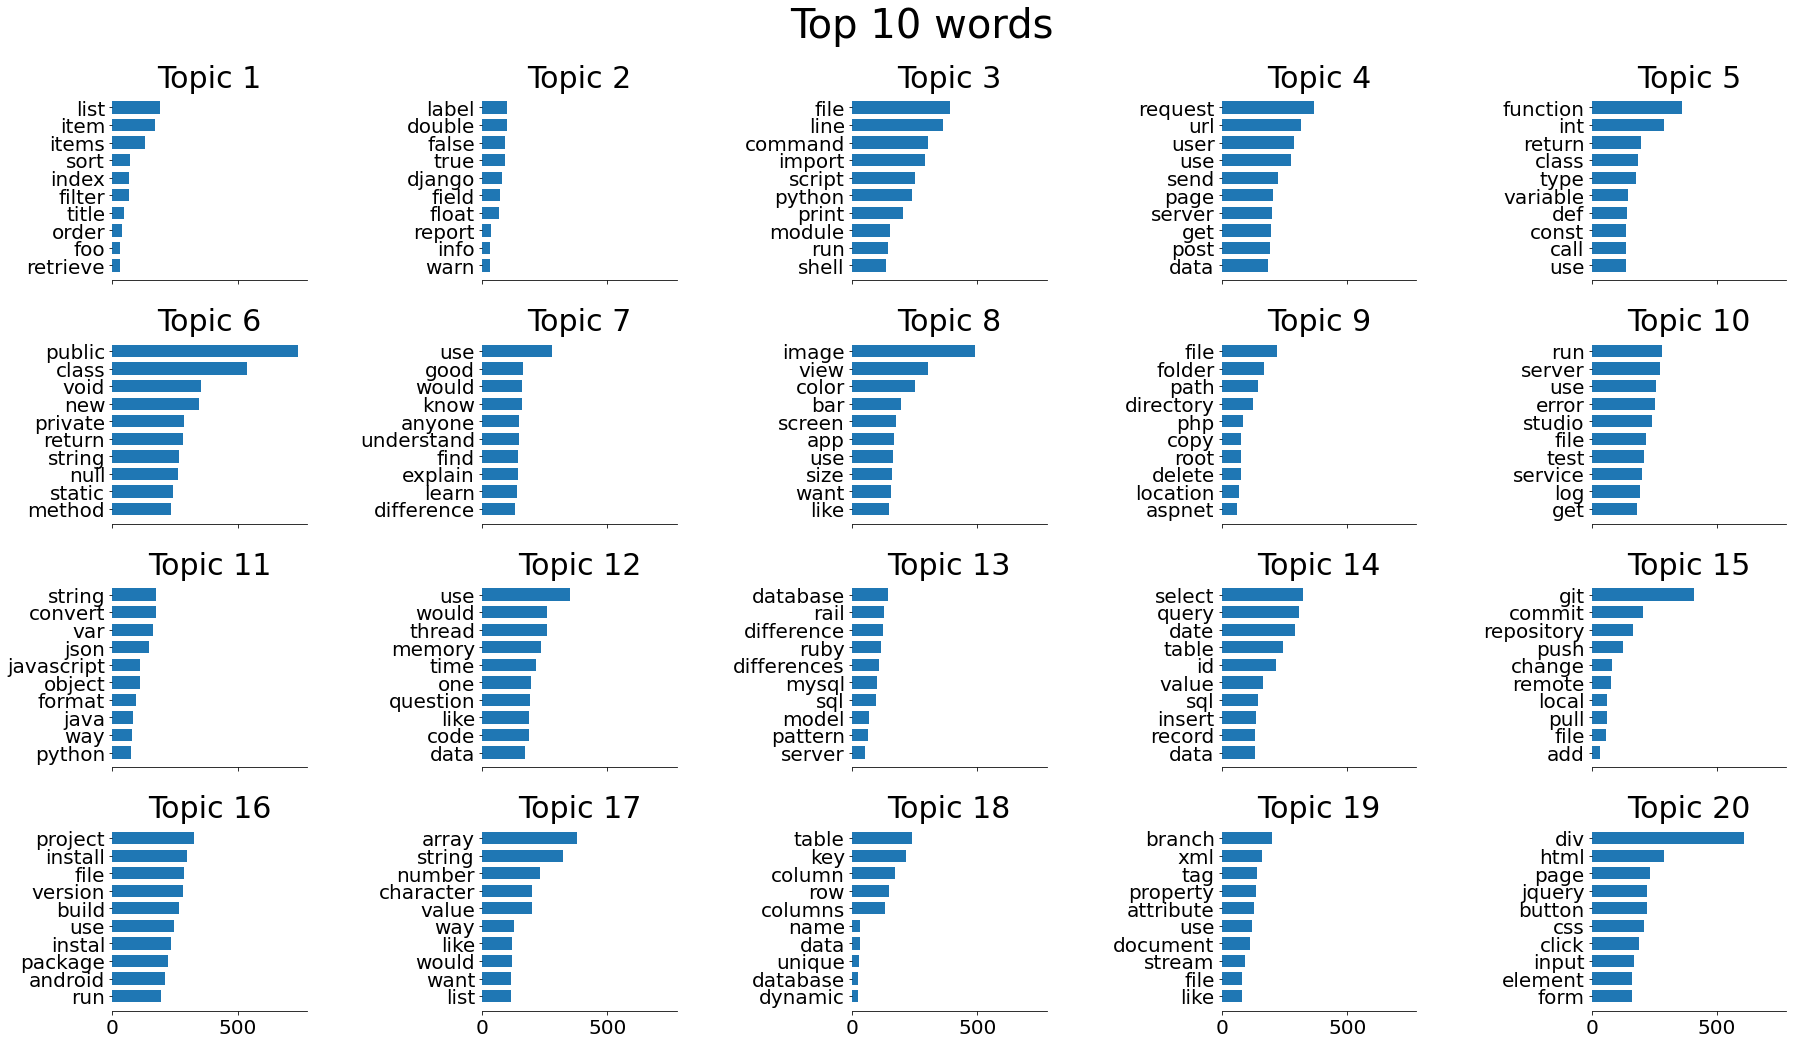

In [147]:
plot_top_words(lda_model, tfidf_vectorizer.get_feature_names(), 10, 'Top 10 words')

## 3.2 NMF

On répète exactement les mêmes étapes pour NMF

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


nmf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.6, init='nndsvd')
nmf.fit(vectorized_body)

no_top_words = 20
display_topics(nmf, tfidf_vectorizer.get_feature_names(), no_top_words)


--------------------------------------------
Topic 0:
would like know look something way find one code question could work make need seem time write example list good
--------------------------------------------
Topic 1:
public void int new return private static null override code method set exception final throw get protect catch view true
--------------------------------------------
Topic 2:
file directory folder open read create copy path upload name include download want save xml write need project content add
--------------------------------------------
Topic 3:
function return call pass def jquery define javascript code false foo ajax script arguments php example else result write inside
--------------------------------------------
Topic 4:
div html width css height input element button page content body jquery text script form position click style scroll leave
--------------------------------------------
Topic 5:
table select query database row sql data column id name mysql key 

In [143]:
display_intertopics(nmf, tfidf_vectorizer.get_feature_names(), 20)


--------------------------------------------
Topic 0:
list
--------------------------------------------
Topic 1:
exception
--------------------------------------------
Topic 2:
file xml
--------------------------------------------
Topic 3:
function javascript php ajax jquery
--------------------------------------------
Topic 4:
jquery html css
--------------------------------------------
Topic 5:
database sql mysql
--------------------------------------------
Topic 6:
exception
--------------------------------------------
Topic 7:
java json string
--------------------------------------------
Topic 8:
image css
--------------------------------------------
Topic 9:
java
--------------------------------------------
Topic 10:
php list
--------------------------------------------
Topic 11:
git
--------------------------------------------
Topic 12:
json list
--------------------------------------------
Topic 13:
java class
--------------------------------------------
Topic 14:
database
-----

Résultat assez comparable que celui de lda.

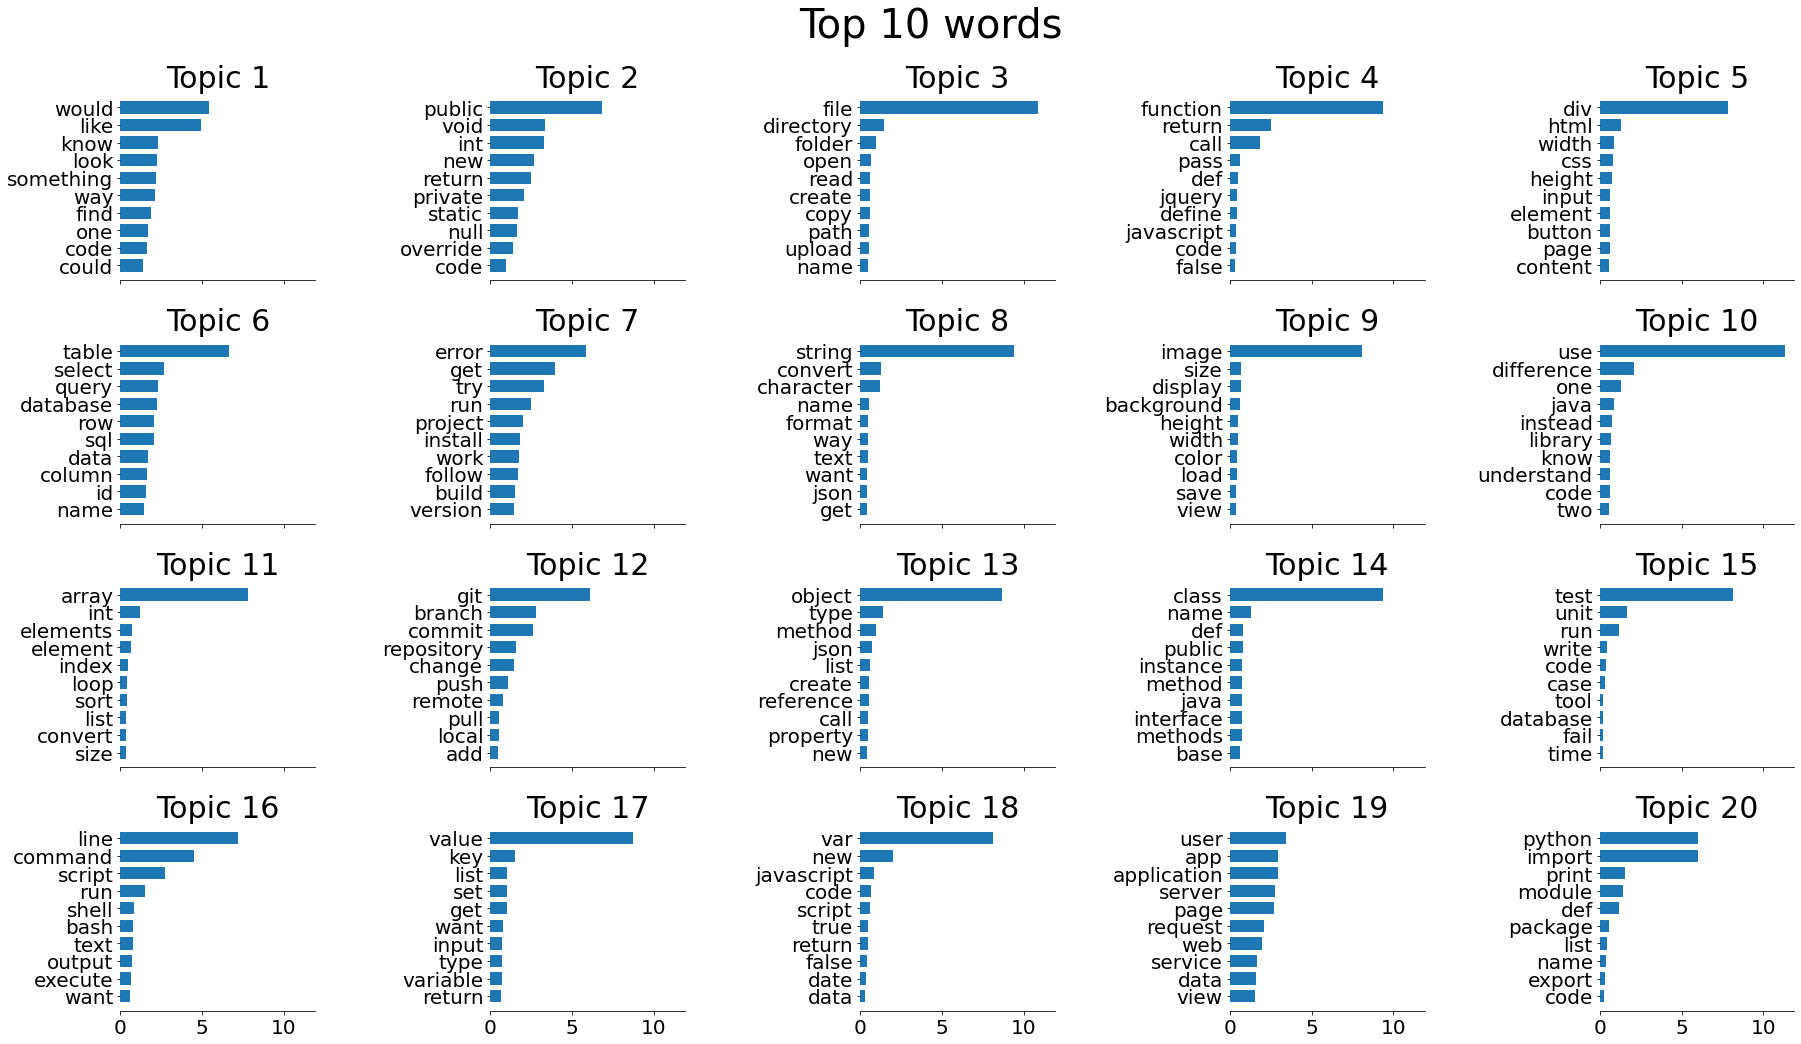

In [148]:
plot_top_words(nmf, tfidf_vectorizer.get_feature_names(), 10, 'Top 10 words')

# 4. Apprentissage supervisé

On testera des modèles de la familles des algorithmes non-linéaires avec OnevsRestClassifier afin qu'ils puissent faire des prédictions multilabels.
Les labels tags seront binarisés grâce à Multilabelbinarizer.

In [60]:
body = df['Body']
title = df['Title']
y = df['Tags']

In [61]:
from sklearn.preprocessing import MultiLabelBinarizer

# Binarisation des tags

binarizer=MultiLabelBinarizer()
binarized_y=binarizer.fit_transform(y)

In [75]:
tfidf_body=TfidfVectorizer(analyzer = 'word',
                min_df=0.002,
                max_df = 0.9,
                strip_accents = None,
                encoding = 'utf-8', 
                preprocessor=None,
                token_pattern=r"(?u)\S\S+")

In [76]:
tfidf_title=TfidfVectorizer(analyzer = 'word',
                min_df=0.002,
                max_df = 0.9,
                strip_accents = None,
                encoding = 'utf-8', 
                preprocessor=None,
                token_pattern=r"(?u)\S\S+")

In [77]:
tfidf_X1=tfidf_body.fit_transform(body)
tfidf_X2=tfidf_title.fit_transform(title)

In [78]:
# On empile les deux matrices représentant les bags of words des features Body et Title
from scipy.sparse import hstack
tfidf_vect=hstack([tfidf_X1, tfidf_X2])

In [127]:
# On réduit la dimension de notre bag of words grâce à une PCA appliquée aux matrices éparses

from sklearn.decomposition import SparsePCA

pca_model = SparsePCA(n_components=200, random_state=0)

PCA_tfidf = pca_model.fit_transform(tfidf_vect.toarray())

In [46]:
# On calcule la somme de la variance cumulée

sum(PCA_tfidf.explained_variance_ratio_)

0.7920941715013482

In [77]:
variance_df=pd.DataFrame({"variance": PCA_tfidf.explained_variance_ratio_})

In [78]:
variance_df.sort_values(by=['variance'], inplace=True)

In [79]:
variance_df.reset_index(inplace=True, drop=True)

In [83]:
variance_df['cum_variance']=variance_df['variance'].cumsum(axis=0)

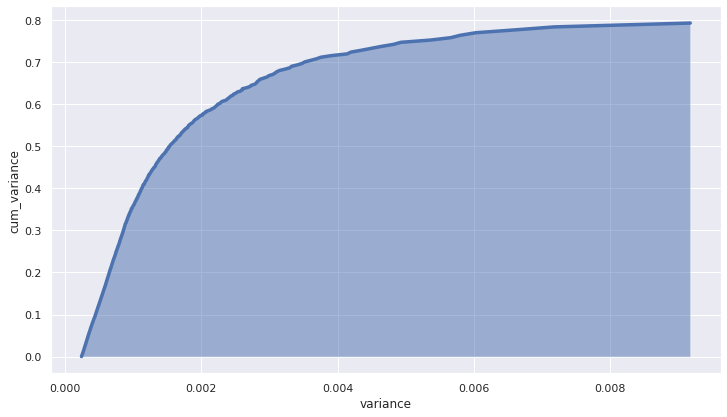

In [105]:
# Graphe de la somme de la variance cumulée

sns.set_theme(style="darkgrid")

sns.set(rc={'figure.figsize':(12, 6.75)})

sns.lineplot(data=variance_df, x="variance", y="cum_variance", linewidth=3.5)

plt.fill_between(variance_df.variance, variance_df.cum_variance, alpha=0.5)

In [101]:
from sklearn.model_selection import train_test_split

# Division des données en données d'entraînement et données de test 

X_train, X_test, y_train, y_test = train_test_split(PCA_tfidf, binarized_y, test_size=0.2, random_state=42)

Le jaccard score a été retenu pour faire office d'évaluation du modèle car il est le plus adapté à la problématique de la prédicton multilabel.

In [25]:
sgd = SGDClassifier()
lr = LogisticRegression()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

In [31]:
for classifier in [sgd, lr, svc, perceptron, pac]:
    classifier=OneVsRestClassifier(classifier)
    classifier.fit(X_train, y_train)
    jacc_score=jaccard_score(y_test, classifier.predict(X_test), average='samples', zero_division=1) - 0.04
    print(classifier)
    print('----')
    print("Jaccard score: {}".format(jacc_score))
    print ('----')

OneVsRestClassifier(estimator=SGDClassifier())
----
Jaccard score: 0.4370616666666667
----
OneVsRestClassifier(estimator=LogisticRegression())
----
Jaccard score: 0.4429416666666666
----
OneVsRestClassifier(estimator=LinearSVC())
----
Jaccard score: 0.4790499999999999
----
OneVsRestClassifier(estimator=Perceptron())
----
Jaccard score: 0.3960870238095238
----
OneVsRestClassifier(estimator=PassiveAggressiveClassifier())
----
Jaccard score: 0.41838047619047625
----


In [44]:
mlp = MLPClassifier()
rf = RandomForestClassifier()

In [70]:
for classifier in [mlp, rf]:
    classifier.fit(X_train, y_train)
    jacc_score=jaccard_score(y_test, classifier.predict(X_test), average='samples', zero_division=1) 
    print(classifier)
    print('----')
    print("Jaccard score: {}".format(jacc_score))
    print ('----')

MLPClassifier()
----
Jaccard score:  0.4698754761904762
----
RandomForestClassifier()
----
Jaccard score:  0.4467291432865006
----


On voit que le meilleur score est obtenu par l'algorithme Support Vector Machine. On le choisira pour notre modèle.

## 5. Optimisation des hyperparamètres

In [109]:
# On définit une métrique pour l'optimisation des hyperparamètres
def percentage_jaccard(y_true,y_pred):
    jaccard = jaccard_score(y_true, y_pred, average='samples', zero_division=1)
    
    return jaccard*100

In [110]:
from sklearn.model_selection import GridSearchCV
 
# On choisit d'optimiser l'hyperparamètre extimator__C
param_grid = {'estimator__C':[1,5,10,20]
              }
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, 
         verbose=10, scoring=make_scorer(percentage_jaccard, greater_is_better=True))

In [111]:
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START estimator__C=1..............................................
[CV 1/5; 1/4] END ..............estimator__C=1;, score=51.879 total time=   9.3s
[CV 2/5; 1/4] START estimator__C=1..............................................
[CV 2/5; 1/4] END ..............estimator__C=1;, score=51.373 total time=  10.0s
[CV 3/5; 1/4] START estimator__C=1..............................................
[CV 3/5; 1/4] END ..............estimator__C=1;, score=50.794 total time=   9.7s
[CV 4/5; 1/4] START estimator__C=1..............................................
[CV 4/5; 1/4] END ..............estimator__C=1;, score=51.894 total time=   9.6s
[CV 5/5; 1/4] START estimator__C=1..............................................
[CV 5/5; 1/4] END ..............estimator__C=1;, score=51.311 total time=   9.5s
[CV 1/5; 2/4] START estimator__C=5..............................................
[CV 1/5; 2/4] END ..............estimator__C=5;, 

/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.

[CV 1/5; 4/4] END .............estimator__C=20;, score=44.559 total time=  29.5s
[CV 2/5; 4/4] START estimator__C=20.............................................


/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.

[CV 2/5; 4/4] END .............estimator__C=20;, score=44.073 total time=  31.0s
[CV 3/5; 4/4] START estimator__C=20.............................................


/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.

[CV 3/5; 4/4] END .............estimator__C=20;, score=43.914 total time=  32.0s
[CV 4/5; 4/4] START estimator__C=20.............................................


/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.

[CV 4/5; 4/4] END .............estimator__C=20;, score=44.330 total time=  30.6s
[CV 5/5; 4/4] START estimator__C=20.............................................


/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/jo/miniconda3/envs/johnny_lerouge/lib/python3.

[CV 5/5; 4/4] END .............estimator__C=20;, score=44.344 total time=  28.8s


GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 5, 10, 20]},
             scoring=make_scorer(percentage_jaccard), verbose=10)

In [112]:
CV_svc.best_estimator_

OneVsRestClassifier(estimator=LinearSVC(C=1))